# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore") 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

## Загрузка и подготовка данных

In [3]:
#создадим 3 датасета и загрузим в них исходные датафремы
data1 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
data2 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
data3 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')

display(data1.head())
display(data1.info())
display(data2.head())
display(data2.info())
display(data3.head())
data3.info()


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Проверим количество дубликатов.

In [4]:
print(data1.duplicated().sum())
print(data2.duplicated().sum())
data3.duplicated().sum()

0
0


0

Выведем общую информацию о данных

In [5]:
display(data1.describe())
display(data2.describe())
data3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Выведем всю информацию нагядно на графиках для каждого региона

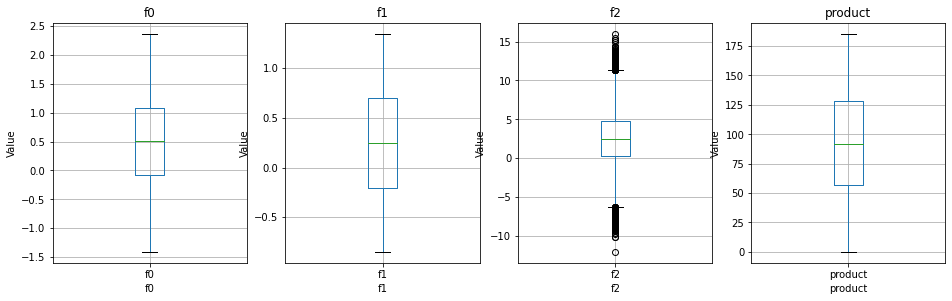

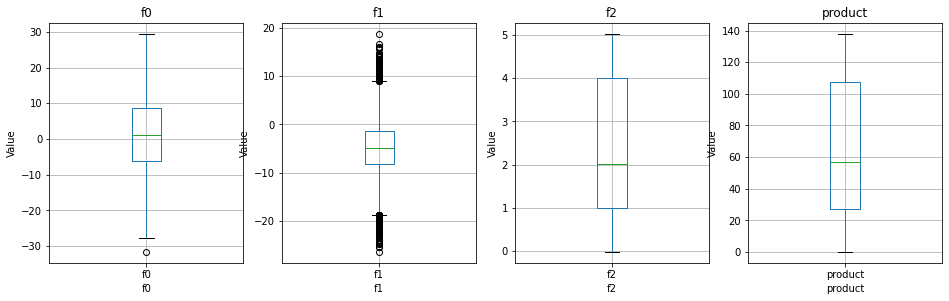

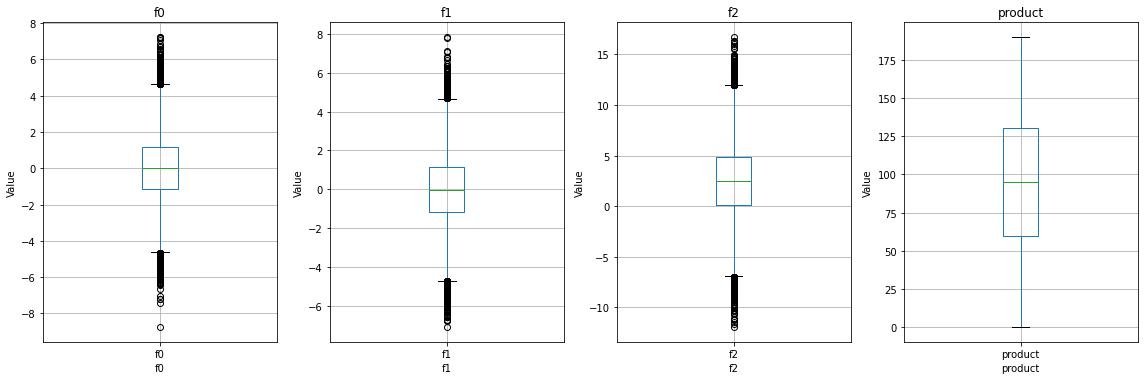

In [6]:
df_list = [data1, data2, data3]
for df in df_list:
# Выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(16, 15))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(3, 4, i + 1)  # 3 строки, 4 столбца, текущий график
    
    # Строим график размаха для текущего столбца
        df.boxplot(column=column, ax=plt.gca())
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Value')
        
plt.tight_layout()
plt.show()

Заметим, что в некоторых столбцах имеются явные выбросы. Такие данные следует почистить


In [7]:
#почистим и проверим данные 1 региона

#граница усов видна неявно, поэтому получим ее значение
q25=np.array(data1['f2'].quantile(0.25))
q75=np.array(data1['f2'].quantile(0.75))
down=q25-1.5*(q75-q25)
up=q75+1.5*(q75-q25)
print('down:',down)
print('up:',up)

down: -6.3532614580838125
up: 11.356097512311544


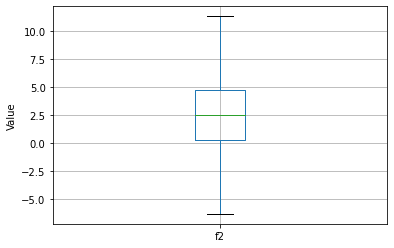

In [8]:
data1 = data1.loc[(data1['f2']<11.3)&(data1['f2']>-6.3)]
data1.boxplot(column='f2', ax=plt.gca())
plt.ylabel('Value')
plt.show()

In [9]:
#почистим и проверим данные 2 региона

#граница усов видна неявно, поэтому получим ее значение
q25=np.array(data2['f1'].quantile(0.25))
q75=np.array(data2['f1'].quantile(0.75))
down=q25-1.5*(q75-q25)
up=q75+1.5*(q75-q25)
print('down:',down)
print('up:',up)


down: -18.670738069582377
up: 9.069937223519565


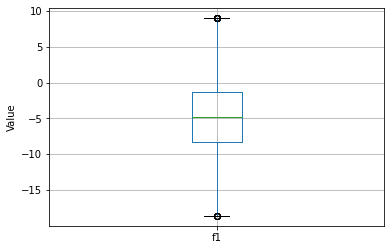

In [10]:
data2 = data2.loc[(data2['f1']<9)&(data2['f1']>-18.6)]
data2.boxplot(column='f1', ax=plt.gca())
plt.ylabel('Value')
plt.show()

In [11]:
#почистим и проверим данные 3 региона

#границы усов видна неявно, поэтому получим их значение
num_columns = data3.select_dtypes(include=['float64']).columns.tolist()
for i in (num_columns):
    q25=np.array(data3[i].quantile(0.25))
    q75=np.array(data3[i].quantile(0.75))
    down=q25-1.5*(q75-q25)
    up=q75+1.5*(q75-q25)
    print('down',i,':', down)
    print('up',i,':', up)

down f0 : -4.643524223522959
up f0 : 4.639771092118378
down f1 : -4.682565825428671
up f1 : 4.671424081839961
down f2 : -6.962293786328402
up f2 : 11.951446027690594
down product : -47.26643772727831
up product : 237.31190538130107


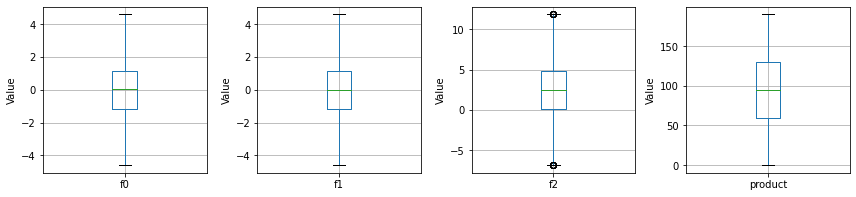

In [12]:
data3 = data3.loc[(data3['f0'] < 4.6) & (data3['f0'] > -4.6)]
data3 = data3.loc[(data3['f1'] < 4.6) & (data3['f1'] > -4.6)]
data3 = data3.loc[(data3['f2'] < 11.9) & (data3['f2'] > -6.9)]
#data3.boxplot(column='f1', ax=plt.gca())

# Создание графиков
plt.figure(figsize=(12, 8))
num_columns = data3.select_dtypes(include=['float64']).columns.tolist()
for i, column in enumerate(num_columns):
    plt.subplot(3, 4, i + 1)  # 3 строки, 4 столбца, текущий график
    data3.boxplot(column=column, ax=plt.gca())
    plt.ylabel('Value')
plt.tight_layout()
plt.show()


Выведем матрицы корреляции для всех датафреймов

In [13]:
data1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440681,-0.003092,0.143673
f1,-0.440681,1.000000,0.000989,-0.192788
f2,-0.003092,0.000989,1.000000,0.479973
product,0.143673,-0.192788,0.479973,1.000000


In [14]:
data2.corr()

,f0,f1,f2,product
f0,1.000000,0.178792,-0.001645,-0.030363
f1,0.178792,1.000000,-0.003020,-0.010438
f2,-0.001645,-0.003020,1.000000,0.999397
product,-0.030363,-0.010438,0.999397,1.000000


Была замечена очень сильная корреляция между входным признаком и целевым, коэффициент корреляции стремится к 1, и скорее всего будет сбивать модель с толку, поэтому этот признак следует удалить, и делать выводы по оставшимся, потому что это является утечкой целевого признака. Дальше работать будем без f2.

In [16]:
data3.corr()

,f0,f1,f2,product
f0,1.000000,0.000474,0.000816,-0.002491
f1,0.000474,1.000000,0.001151,-0.000548
f2,0.000816,0.001151,1.000000,0.440969
product,-0.002491,-0.000548,0.440969,1.000000


**Вывод:** <br/>
в первом регионе на целевой признак самое большое влияние оказывает фактор f2 - 0.47 коэф. корреляции <br/>
во втором регионе на целевой признак оказывает влияение только f2 - коэф = 0.999 <br/>
в третьем регионе на целевой признак влияет тоже в основном только f2 - коэф = 0.44 <br/><br/>

**Вывод по обработке данных:**<br/>
Данные были проверены на пропуски, дубликаты, были удалены выбросы и проверена корреляция входных признаков с целевым. Во втором датфрейме было решено удалить входной признак, который коррелировал с целевым почти на 1. Данные подготовлены к дальнейшей работе.

## Обучение и проверка модели

In [17]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

dataframes = [data1, data2, data3]

print('Значения для трех датафреймов:\n')

# Список для сохранения новых датафреймов
target_dataframes = []

for i, df in enumerate(dataframes):
    X = df.drop(["id", "product"], axis=1)
    y = df["product"]
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    
    new_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    new_pipeline.fit(X_train, y_train)
    y_pred = new_pipeline.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred) ** 0.5
    
    # Создаем новый датафрейм с предсказаниями и реальными значениями
    result_df = pd.DataFrame({
        'real': y_valid,
        'pred': y_pred
    })
    
    # Сохраняем новый датафрейм в список
    target_dataframes.append(result_df)
    
    print(f'Средний запас предсказанного сырья для датафрейма {i+1}:', y_pred.mean())
    print(f'Значение ошибки на модели для датафрейма {i+1}:', rmse)
    print()

Значения для трех датафреймов:

Средний запас предсказанного сырья для датафрейма 1: 92.47754031300094
Значение ошибки на модели для датафрейма 1: 37.899021865194115

Средний запас предсказанного сырья для датафрейма 2: 68.9029064825551
Значение ошибки на модели для датафрейма 2: 0.8942221643598804

Средний запас предсказанного сырья для датафрейма 3: 94.69096686410404
Значение ошибки на модели для датафрейма 3: 39.943639093269304



In [18]:
#создадим 3 новых переменных в которые занесем предсказания и реальные обьемы
target1 = target_dataframes[0]
target2 = target_dataframes[1]
target3 = target_dataframes[2]

In [19]:
target1.describe()

,real,pred
count,24864.000000,24864.000000
mean,92.767397,92.477540
std,44.460425,23.149737
min,0.000000,20.507026
25%,56.724964,76.576607
50%,91.812513,92.605994
75%,129.055519,108.480895
max,185.354980,163.069126


In [20]:
target2.describe()

,real,pred
count,24836.000000,24836.000000
mean,68.911941,68.902906
std,46.028018,46.014283
min,0.000000,-2.015456
25%,26.953261,28.538129
50%,57.085625,58.066571
75%,107.813044,109.359751
max,137.945408,139.982206


In [21]:
target3.describe()

,real,pred
count,24462.000000,24462.000000
mean,94.853736,94.690967
std,44.468440,19.721796
min,0.000000,39.853085
25%,59.699316,81.018088
50%,95.038101,94.551021
75%,130.021239,108.417357
max,189.979704,149.582641


Мы вывели значения всех требуемых значений для трех датафреймов. Выводы получаются такими, что самый большой обьем сырья предсказывается в 3 регионе - 94.7, но в этом регионе самое большое значение ошибки модели. Во втором регионе самая маленькая ошибка, скорее всего из-за сильной корреляции входного признака с целевым, но в любом случае, нам с этим регионом врятли придется работать, так как там самые низкие показатели по обьему добываемого сырья - 68.9. В 1 регионе значения обьемов и ошибки довольно близки к 3 региону, но оба показателя меньше.

## Подготовка к расчёту прибыли

In [22]:
#введем необходимые константы 
all_points = 500
best_points = 200
budget = 10000000000
price_per_barrel = 450000

damage_treshold =  0.025 #вероятность убытков

In [23]:
#рассчитаем объем сырья, чтобы выйти в плюс
non_damage_value = (budget/(price_per_barrel))/best_points
print("Достаточный объём сырья для безубыточной разработки новой скважины",round(non_damage_value,2))

Достаточный объём сырья для безубыточной разработки новой скважины 111.11


Мы получили такое значение, при котором скважина начнет приносить прибыль это 111.1. В среднем каждый из регионов приносит меньше этого обьема, значит для наших целей подойдет довольно малая часть скважин.

In [24]:
display(data1.describe())
display(data2.describe())
data3.describe()

,f0,f1,f2,product
count,99455.000000,99455.000000,99455.000000,99455.000000
mean,0.500625,0.250072,2.503490,92.501878
std,0.871849,0.504443,3.177016,44.227156
min,-1.408605,-0.848218,-6.296441,0.000000
25%,-0.072327,-0.201052,0.302271,56.569867
50%,0.502639,0.250038,2.516342,91.842786
75%,1.073731,0.700608,4.702998,128.513356
max,2.362331,1.343769,11.296029,185.364347


,f0,f1,f2,product
count,99342.000000,99342.000000,99342.000000,99342.000000
mean,1.140103,-4.802545,2.493950,68.809579
std,8.965949,4.980411,1.703254,45.935275
min,-31.609576,-18.599840,-0.018144,0.000000
25%,-6.299865,-8.248387,1.000016,26.953261
50%,1.150199,-4.816117,2.011374,57.085625
75%,8.621050,-1.364062,3.999893,107.813044
max,29.421755,8.993895,5.019721,137.945408


,f0,f1,f2,product
count,97848.000000,97848.000000,97848.000000,97848.000000
mean,0.001620,-0.002321,2.493791,94.758694
std,1.677402,1.676726,3.387134,44.685961
min,-4.599275,-4.598167,-6.899536,0.000000
25%,-1.152132,-1.162989,0.147625,59.304378
50%,0.009417,-0.009353,2.482386,94.667404
75%,1.148185,1.154078,4.838957,130.286025
max,4.597004,4.598268,11.893861,190.029838


Выведя статистическую информацию по всем скважинам мы получаем, что в 1 и 3 регионе как минимум по 25% скважин нам подходят по обьемам, а во 2 регионе немного меньше, но подходящие скважины там тоже есть.

In [25]:
#напишем функцию расчета прибыли

def revenue(target, probabilities, count):
    
    # Выберите скважины с максимальными значениями предсказаний. 
    probs_sorted = probabilities.sort_values(ascending=False)
    
    #Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
    selected = target[probs_sorted.index][:count] 
    
    #Рассчитайте прибыль для полученного объёма сырья.
    return (price_per_barrel * selected.sum()) - budget


## Расчёт прибыли и рисков 

Теперь рассчитаем потенциальную прибыль в каждом из регионов с помощью метода Bootstrap.

In [34]:
def bootstrap(target, probabilities, count, number):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        revenue_value = revenue(target_subsample,probs_subsample,count)
        values.append(revenue_value)
        
    values = pd.Series(values)
    values_mean = values.mean()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    risk = values.loc[values<0].count()/values.count()*100
    
    print(f'Средняя прибыль в регионе {number} составляет {values_mean/1000000} млн. рублей')
    print(f'95% доверительный интервал составляет от {lower/1000000} млн. до {upper/1000000} млн.')
    print(f'Доля убыточных скважин в регионе составляет {risk} %')

In [35]:
boot1 = bootstrap(target1['real'], target1['pred'], best_points, 1)
boot1

Средняя прибыль в регионе 1 составляет 463.8446615001039 млн. рублей
95% доверительный интервал составляет от -93.06385880410441 млн. до 1000.5645618479704 млн.
Доля убыточных скважин в регионе составляет 5.5 %


In [36]:
boot2 = bootstrap(target2['real'], target2['pred'], best_points, 2)
boot2

Средняя прибыль в регионе 2 составляет 524.666200911411 млн. рублей
95% доверительный интервал составляет от 111.68537052744361 млн. до 932.9548624820623 млн.
Доля убыточных скважин в регионе составляет 0.5 %


In [37]:
boot3 = bootstrap(target3['real'], target3['pred'], best_points, 3)
boot3

Средняя прибыль в регионе 3 составляет 341.86636931387255 млн. рублей
95% доверительный интервал составляет от -196.98930144409886 млн. до 916.7813836993864 млн.
Доля убыточных скважин в регионе составляет 11.0 %


Исходя из полученных значений можно сделать вывод, что из предложенных регионов лучшим по показателям средней прибыли является 1 регион. Средняя прибыль в нем составляет 463.84 млн рублей, против 341.86 млн в 3 регионе. <br/>

Довольно странно получилось то, что 2 регион определился как лучший регион, хотя до этого показатели были хуже чем в остальных. Я бы не стала доверять таким выводам, и не рассматривала его как кандидата, так как данные изначально отличались от двух других регионов и по ощущениям содержали в себе ошибку. <br/>
Если ошибки никакой нет, то заказчик смело может брать 2 регион для постройки скважин, но лучше пересмотреть входные данные еще раз. Если же во входных данных действительно есть ошибка, то лучшим регионом оказался 1: <br/>
Риски убытков составляют 5.5%, что является самым низким показателем из всех регионов, но все равно не удовлетворяющего условию задачи.<br/>
Также границы доверительного интервала - большие числа, по сравнению с интревалами других регионов.<br/><br/>

**Итоговый вывод**<br/><br/>
Полностью под условия заказчика не подходит ни одна из скважин, так как минимальный показатель риска среди всех регионов - 5.5%. Но если выбирать из представленных, лучшим будет первый регион, так как в нем меньше всего убыточных скважин(5.5%), самый большой показатель средней прибыли(464 млн. руб.) и нижняя граница доверительного интервала самая низкая из всех регионов(-93 млн руб)

